In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")

import visualpipe.post_analysis.utils as ut
import visualpipe.post_analysis.plot_functions as pltf

## Inputs

In [ ]:
excel_sheet_path = "../src/visualpipe/post_analysis/Nathan_sessions.xlsx"
save_path = ""

protocol_name = 'surround-mod' # Name of the protocol to analyze (e.g. 'surround-mod', 'visual-survey'...)
neuron_type = "PYR"

group_column = 'Genotype'
groups_id = {'WT': 0, 'KO': 1}

attr = 'dFoF0-baseline'
frame_rate = 30 # Frame rate

suffix = f"{neuron_type}_per_{group_column}"

In [3]:
df = ut.load_excel_sheet(excel_sheet_path, protocol_name, neuron_type=neuron_type)
df

Mice included : [109 112 108 110]


,Session_id,Output_id,Protocol,Mouse_id,Genotype,Neuron_type,Analyze,Session_path
0,2025_03_04_14-04-14,7,surround-mod,109,KO,PYR,1,Y:\raw-imaging\Nathan\PYR\109 male\Visual\2025...
1,2025_03_07_14-54-09,3,surround-mod,109,KO,PYR,1,Y:\raw-imaging\Nathan\2025_03_07\TSeries-03072...
2,2025_03_14_16-02-13,4,surround-mod,112,KO,PYR,1,Y:\raw-imaging\Nathan\PYR\112 female\Visual\14...
3,2025_03_24_16-38-34,4,surround-mod,112,KO,PYR,1,Y:\raw-imaging\Nathan\PYR\112 female\Visual\24...
4,2025_03_24_18-00-31,4,surround-mod,112,KO,PYR,1,Y:\raw-imaging\Nathan\PYR\112 female\Visual\24...
5,2025_03_03_18-32-04,3,surround-mod,108,WT,PYR,1,Y:\raw-imaging\Nathan\PYR\108 male\Visual\03_0...
6,2025_02_25_14-12-40,9,surround-mod,110,WT,PYR,1,Y:\raw-imaging\Nathan\PYR\110 male\Visual\25_0...
7,2025_03_03_17-03-02,5,surround-mod,110,WT,PYR,1,Y:\raw-imaging\Nathan\PYR\110 male\Visual\03_0...


In [4]:
period_names = ut.get_period_names(attr)

nb_neurons = {} # Nb of neurons for each group
nb_valid_neurons = [] # Nb of valid neurons per stimuli for each group
av_trial_traces = [] # Average traces per stimuli for each group

for group in groups_id.keys():
    print(f"\n-------------------------- Processing {group} group --------------------------")
    df_filtered = df[df[group_column] == group]
    nb_sessions_group = len(df_filtered)
    print(f'Nb of sessions for {group}: {nb_sessions_group}')

    av_trial_traces_group = {}
    nb_valid_neurons_group = {}
    
    for k in range(len(df_filtered)):
        mouse_id, session_id, output_id, session_path = utils = ut.get_session_metadata(df_filtered, k)
        print(f"\nSession id: {session_id}\n  Mouse id : {mouse_id}\n     Session path: {session_path}")

        validity, trials, stimuli_df = ut.load_data_session(session_path)

        ut.sum_value_in_dict(nb_neurons, group, trials['trial_averaged_zscores'][0].shape[0])
        
        for stim in validity.keys():
            valid_neurons = np.where(np.array([np.abs(el[0]) for el in validity[stim]]) == 1)[0]
            ut.sum_value_in_dict(nb_valid_neurons_group, stim, len(valid_neurons))

            stim_id = stimuli_df[stimuli_df.name == stim].index[0]

            # Get average trace
            traces = np.concatenate([trials[period][stim_id][valid_neurons, :] for period in period_names], axis=1)
            avg_trace = np.mean(traces, axis=0)
            ut.sum_list_in_dict(av_trial_traces_group, stim, avg_trace)
    
    nb_valid_neurons.append(nb_valid_neurons_group)
    av_trial_traces.append(av_trial_traces_group)

stim_list = list(validity.keys()) # List of stimuli
dt_pre_stim = trials['dt_pre_stim'] # Pre-stimulus time


-------------------------- Processing WT group --------------------------
Nb of sessions for WT: 3

Session id: 2025_03_03_18-32-04
  Mouse id : 108
     Session path: Y:\raw-imaging\Nathan\PYR\108 male\Visual\03_03_2025\TSeries-03032025-012\2025_03_03_18-32-04_output_3

Session id: 2025_02_25_14-12-40
  Mouse id : 110
     Session path: Y:\raw-imaging\Nathan\PYR\110 male\Visual\25_02_2025\TSeries-02252025-002\2025_02_25_14-12-40_output_9

Session id: 2025_03_03_17-03-02
  Mouse id : 110
     Session path: Y:\raw-imaging\Nathan\PYR\110 male\Visual\03_03_2025\TSeries-03032025-005\2025_03_03_17-03-02_output_5

-------------------------- Processing KO group --------------------------
Nb of sessions for KO: 5

Session id: 2025_03_04_14-04-14
  Mouse id : 109
     Session path: Y:\raw-imaging\Nathan\PYR\109 male\Visual\2025_03_04\TSeries-03042025-009\2025_03_04_14-04-14_output_7

Session id: 2025_03_07_14-54-09
  Mouse id : 109
     Session path: Y:\raw-imaging\Nathan\2025_03_07\TSeries-03

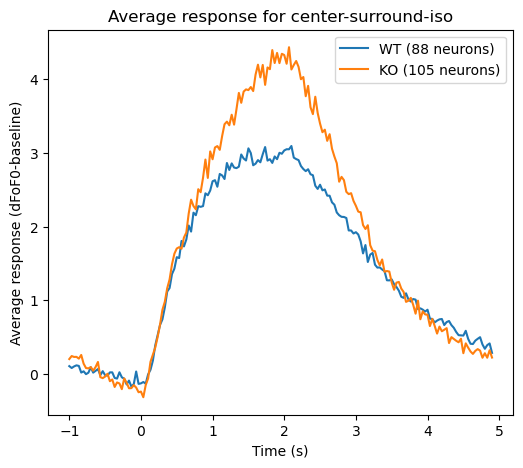

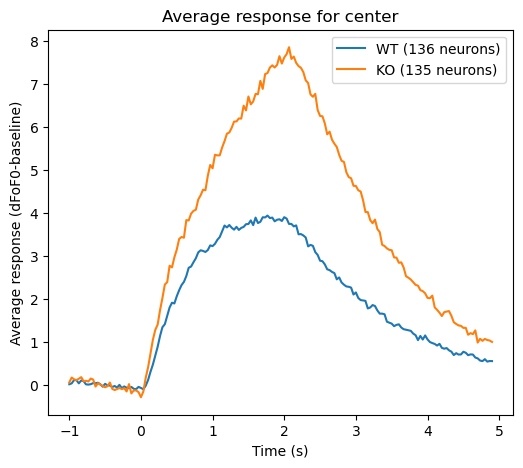

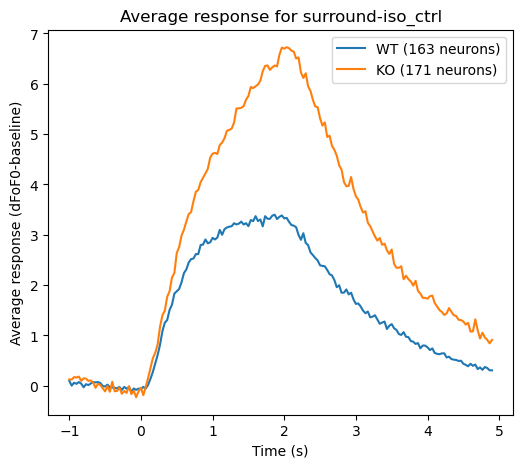

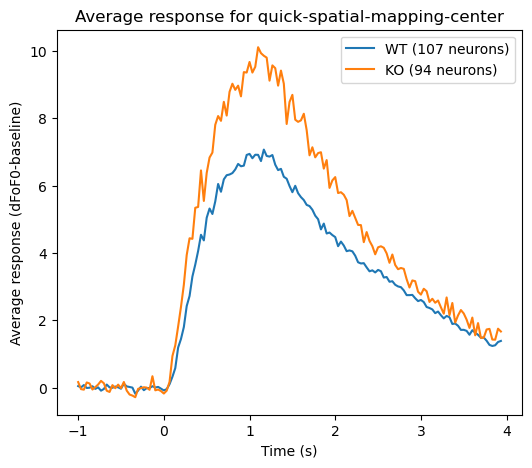

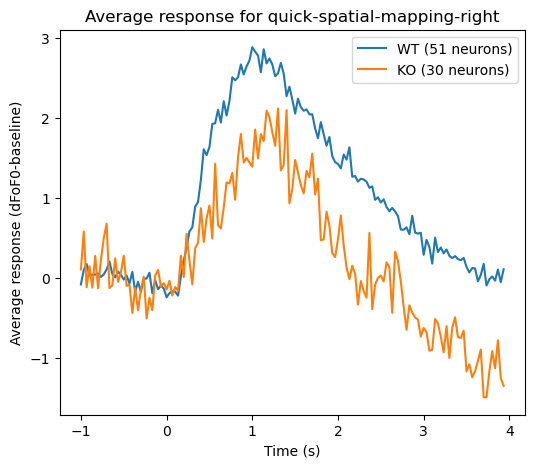

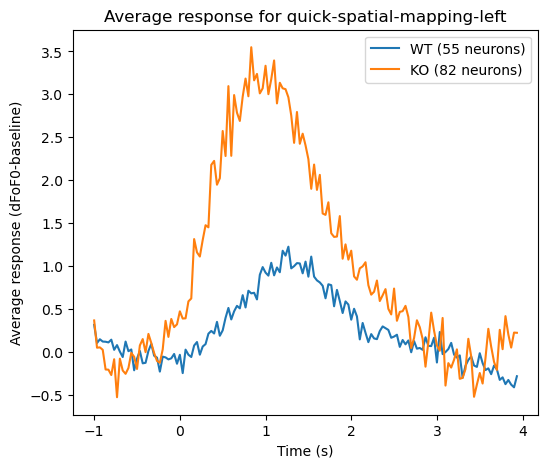

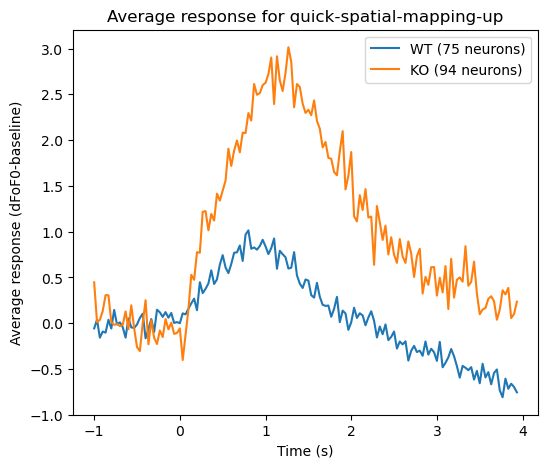

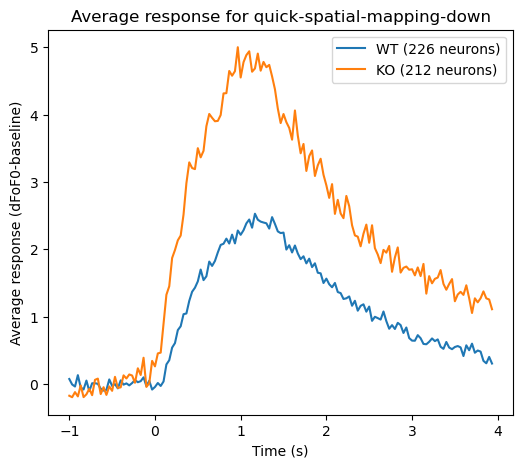

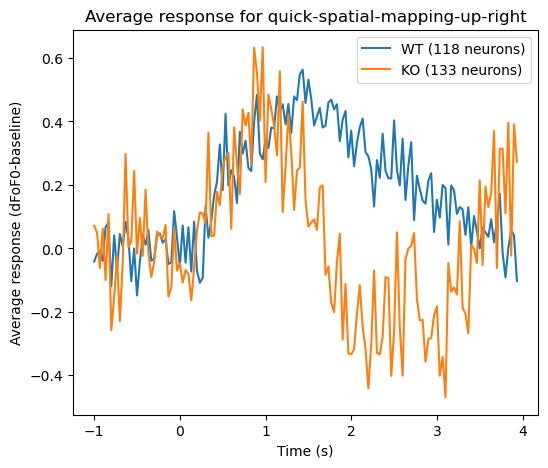

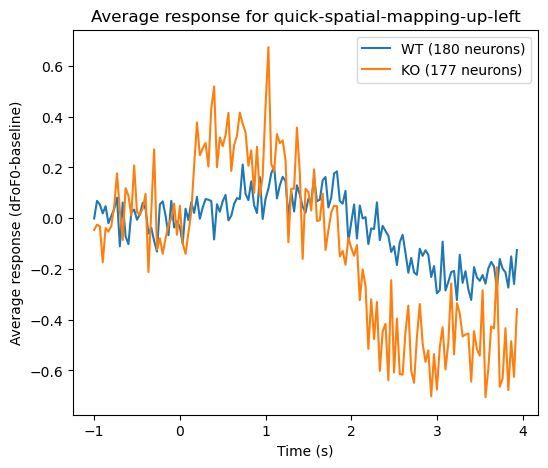

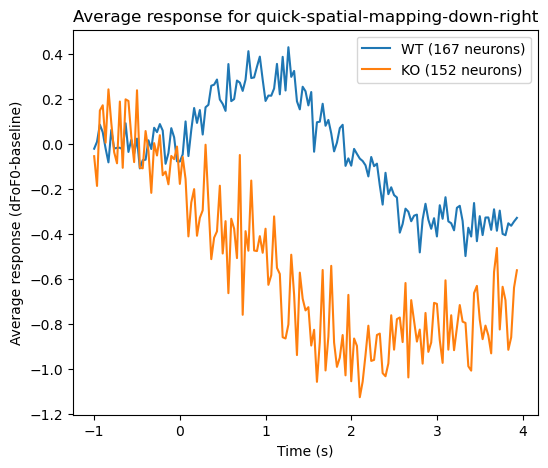

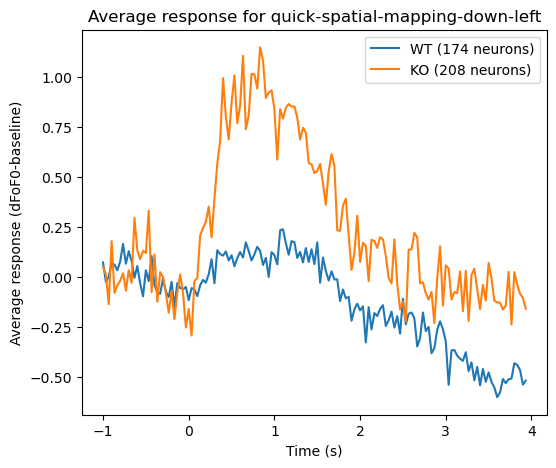

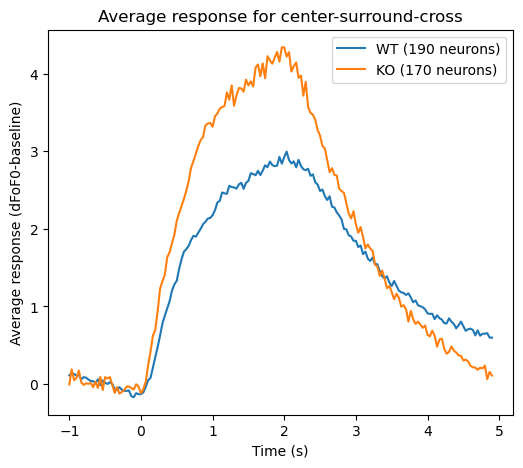

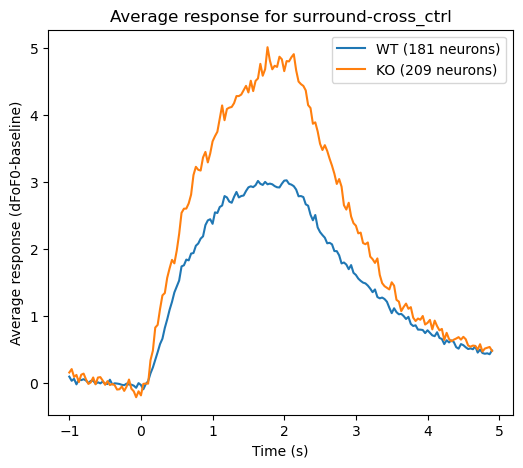

In [5]:
for stim in stim_list :
    time = (np.arange(av_trial_traces[groups_id[group]][stim].shape[0]) / frame_rate) - dt_pre_stim
    pltf.plot_traces(av_trial_traces, stim, groups_id, time, nb_valid_neurons, attr, suffix, save_path, show=True)